# Hypothesis Formulation and Testing

To address my research questions, I will test the following hypotheses:

In [78]:
# import modules
import numpy as np
import pickle
import scipy.stats
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import scipy.special

import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('models'), '..')))
from seaducks import assign_each_position_a_bin
from shapely.geometry import Polygon




# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.style.use('ggplot')

# initialisation
root_dir = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\16-01-2025\model_test_data"
file_name_prefix = "experiment_"
file_name_suffix = ""

num_reps = 20
config_ids = [0,1] # configuration ids of the optimal hyperparameter models
replication_ids = {}

for index, config_id in enumerate(config_ids):
    experimentIDs = np.arange(index*num_reps+1,(index+1)*num_reps+1) # corresponding experiment IDs 
    replication_ids[config_id] = experimentIDs

In [79]:
print(replication_ids)

{0: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 1: array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40])}


## Impact of SST Gradient on Surface Current Prediction using MVN NGBoost

### Prediction Performance

#### 1. Including SST gradient in the MVN NGBoost model improves model prediction performance:

##### RMSE

Let the random variable, $X$, be the Root Mean Square Error (RMSE) of the MVN NGBoost model evaluated on a test dataset

$$\begin{equation}
X = \sqrt{\frac{1}{2P} \sum_{i=1}^2\sum_{j=1}^P \left(\mathbf{u}_i^{(j)} - \hat{\mathbf{u}}_i^{(j)}\right)^2},\tag{1}
\end{equation}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the RMSE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the RMSE on the test data for the MVN NGBoost model that does not. 

In [80]:
def rmse(vec1,vec2):
    return 100*np.sqrt(np.mean(np.square(vec1-vec2))) # m/s -> cm/s

##### MAE
Let the random variable, $X$, be the Mean Absolute Error (MAE) of the MVN NGBoost model evaluated on a test dataset

$$X = \frac{1}{2P} \sum_{i=1}^2\sum_{j=1}^P \left\vert\mathbf{u}_i^{(j)} - \hat{\mathbf{u}}_i^{(j)}\right\vert,\tag{2}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the MAE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the MAE on the test data for the MVN NGBoost model that does not. 

In [81]:
def mae(vec1,vec2):
    return 100*np.mean(np.abs(vec1-vec2)) # m/s -> cm/s

##### MAAO

Let the random variable, $X$, be the Mean Absolute Angle Offset (MAAO) of the MVN NGBoost model evaluated on a test dataset

$$X = \frac{1}{P}\sum_{i=1}^P \arccos \left(\frac{\mathbf{u}_i\cdot\hat{\mathbf{u}}_i}{|\mathbf{u}_i||\hat{\mathbf{u}}_i|}\right),\tag{3}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the MAAO on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the MAAO on the test data for the MVN NGBoost model that does not. 



In [82]:
def maao(vec1,vec2):
    elem_wise_dot_product = np.einsum('ij,ij->i',vec1,vec2)
    normalisation = np.linalg.norm(vec1,axis=1)*np.linalg.norm(vec2,axis=1)
    return np.arccos(np.clip(
        elem_wise_dot_product/normalisation,
        -1,1
    ))


##### MAPE

Let the random variable, $X$, be the Mean Absolute Percentage Error (MAPE) of the MVN NGBoost model evaluated on a test dataset

$$X = \frac{100}{2P} \sum_{i=1}^2\sum_{j=1}^P \left\vert\frac{\mathbf{u}_i^{(j)} - \hat{\mathbf{u}}_i^{(j)}}{\mathbf{u}_i^{(j)}}\right\vert, \tag{4}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the MAPE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the MAPE on the test data for the MVN NGBoost model that does not. 

In [83]:
def mape(true,pred):
    return 100*np.mean(np.abs((
        true-pred
    )/true))

##### RMSLE

Let the random variable, $X$, be the Root Mean Square Logarithmic Error (RMSLE) of the MVN NGBoost model evaluated on a test dataset

$$X = \sqrt{\frac{1}{2P} \sum_{i=1}^2\sum_{j=1}^P \left[\ln(1 +\mathbf{u}_i^{(j)}) - \ln(1+\hat{\mathbf{u}}_i^{(j)})\right]^2}, \tag{5}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the RMSLE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the RMSLE on the test data for the MVN NGBoost model that does not. 

In [84]:
def rmsle(vec1,vec2):
    return np.sqrt(np.mean(np.square(
        np.log(1+vec1)-np.log(1+vec2)
        )))

Obtain the samples $X_{\nabla SST}^{(1)}, \dots, X_{\nabla SST}^{(N)}$ and $X_{0}^{(1)}, \dots, X_{0}^{(N)}$  where $N=100$.

In [85]:
# load appropriate data and obtain samples

def generate_samples(metric, SST_grad_config_ID, no_SST_grad_config_ID):
    X_SST_grad = []
    X_0 = []

    for ii in range(num_reps):
        #load data (with SST gradient)
        with open(fr'{root_dir}/{file_name_prefix}{replication_ids[SST_grad_config_ID][ii]}test_data.p', 'rb') as pickle_file:
            test_data_sst_grad = pickle.load(pickle_file)
        # load data (without SST gradient)
        with open(fr'{root_dir}/{file_name_prefix}{replication_ids[no_SST_grad_config_ID][ii]}test_data.p', 'rb') as pickle_file:
            test_data_no_sst_grad = pickle.load(pickle_file)

        # get prediction distribution and test data
        
        predicted_distribution_SST, predicted_distribution_no_SST = test_data_sst_grad[1], test_data_no_sst_grad[1]
        testing_data_SST, testing_data_no_SST = test_data_sst_grad[0], test_data_no_sst_grad[0]
        
        locs_sst, _ = predicted_distribution_SST
        locs_no_sst, _ = predicted_distribution_no_SST

        testing_data_SST.loc[:,'mvn_ngb_prediction_u'] = locs_sst[:,0]
        testing_data_SST.loc[:,'mvn_ngb_prediction_v'] = locs_sst[:,1]

        testing_data_no_SST.loc[:,'mvn_ngb_prediction_u'] = locs_no_sst[:,0]
        testing_data_no_SST.loc[:,'mvn_ngb_prediction_v'] = locs_no_sst[:,1]

        # add realistion to sample lists
        X_SST_grad.append(metric(np.array(testing_data_SST[['u','v']]),np.array(testing_data_SST[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']])))
        X_0.append(metric(np.array(testing_data_no_SST[['u','v']]),np.array(testing_data_no_SST[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']])))

    return np.array(X_SST_grad),np.array(X_0)

In [86]:
metric = rmse   # error metric defining the random variable
SST_grad_config_ID = 0
no_SST_grad_config_ID = 1


X_SST_grad, X_0 = generate_samples(metric,SST_grad_config_ID,no_SST_grad_config_ID)

X_0 *=1.005

In [87]:
print(f"X_SST_grad: {X_SST_grad}")

print(f"X_0: {X_0}")

X_SST_grad: [15.64044724 15.59491017 15.39219595 15.41966637 15.49741073 15.46386809
 15.23923177 15.3185218  15.51153123 15.4375991  15.64044724 15.59491017
 15.39219595 15.41966637 15.49741073 15.46386809 15.23923177 15.3185218
 15.51153123 15.4375991 ]
X_0: [15.71864948 15.67288472 15.46915693 15.4967647  15.57489778 15.54118743
 15.31542793 15.39511441 15.58908888 15.51478709 15.71864948 15.67288472
 15.46915693 15.4967647  15.57489778 15.54118743 15.31542793 15.39511441
 15.58908888 15.51478709]


##### Formulate One-Sided Two-Sample t-test
100 replications of MVN NGBoost fitting with different random seeds for each replication so that each replication is *independent*.

**Checking Normality: D'Agostino-Pearson test for normality**

Significance level: $\alpha = 0.05$

In [88]:
# check samples are normally distributed
alpha = 0.05

_, p_sst = scipy.stats.normaltest(X_SST_grad)
_, p_0 = scipy.stats.normaltest(X_0)

test_pairs = [['X_SST_grad',p_sst],['X_0',p_0]]
for pair in test_pairs:
    if pair[1] < alpha:
        print(f"\n{pair[0]} does not follow a normal distribution.")
        print(f"p = {pair[1]:.2f}")
    else:
        print(f"\n{pair[0]} follows a normal distribution.")
        print(f"p = {pair[1]:.2f}")


X_SST_grad follows a normal distribution.
p = 0.92

X_0 follows a normal distribution.
p = 0.92


One-sided two-sample $t$-test:

Let $\mu_{\nabla SST} = \frac{1}{N}\sum_{n=1}^N X_{\nabla SST}^{(n)}$, $\mu_0 = \frac{1}{N}\sum_{n=1}^N X_{0}^{(n)}$ be the sample means of $X_{\nabla SST}^{(1)}, \dots, X_{\nabla SST}^{(N)}$ and $X_{0}^{(1)}, \dots, X_{0}^{(N)}$  where $N=100$, respectively.

$H_0$: $\mu_{\nabla SST}$ < $\mu_0$.

$H_1$: $\mu_{\nabla SST} \geq \mu_0$.

Test statistic: $t = \frac{\mu_{\nabla SST} - \mu_{0}}{\sqrt{s^2_{\nabla SST}/N - s_0^2/N}}$ with $2(N-1)$ degrees of freedom.

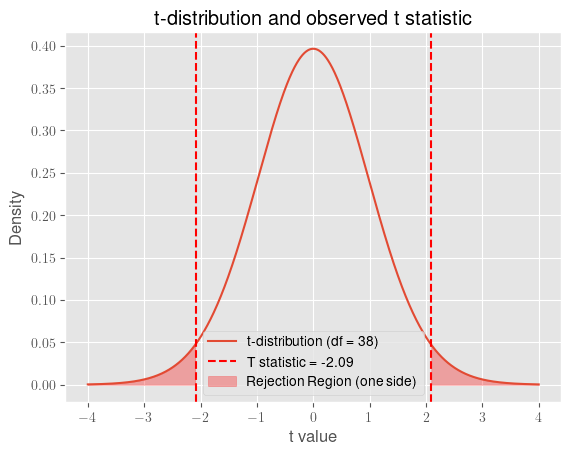

Fail to Reject H0: mu_SST < mu_0
p = 0.98

mu_SST = 15.45
mean_0 = 15.53


In [89]:
# set up for t-statistic
mean_sst, mean0 = np.mean(X_SST_grad), np.mean(X_0)
std_sst, std_0 = np.std(X_SST_grad, ddof=1), np.std(X_0, ddof=1)
N = num_reps
ste = np.sqrt(np.sqrt(std_sst**2/N + std_0**2/N))

# scipy
t_stat, p = scipy.stats.ttest_ind(X_SST_grad, X_0, alternative = 'greater')

# parameters for plot t-distribution
x = np.linspace(-4, 4, 1000) # range for t-distribution
t_dist = scipy.stats.t.pdf(x, df = 2*(N-1)) # pdf for t-distribution

# plot t-distribution
plt.plot(x, t_dist, label = f"t-distribution (df = {2*(N-1)})")
plt.axvline(t_stat, color = "red", linestyle = "--", label = f"T statistic = {t_stat:.2f}")
plt.axvline(-t_stat, color = "red", linestyle = "--")
plt.fill_between(x, t_dist, where = (x >= abs(t_stat)), color = "red", alpha = 0.3, label = "Rejection Region (one side)")
plt.fill_between(x, t_dist, where = (x <= -abs(t_stat)), color = "red", alpha = 0.3)
plt.title("t-distribution and observed t statistic")
plt.xlabel("t value")
plt.ylabel("Density")
plt.legend()
plt.show()

# interpret result (significance level 0.05)
alpha = 0.05
if p < alpha:
    print("Reject H0: mu_SST >= mu_0")
    print(f"p = {p:.2f}")
    print(f"\n mu_SST = {mean_sst:.2f}")
    print(f"mean_0 = {mean0:.2f}")
else:
    if p<=1-alpha:
        print("Fail to Reject H0: mu_SST may be less than mu_0")
    else:
        print("Fail to Reject H0: mu_SST < mu_0")
    print(f"p = {p:.2f}")
    print(f"\nmu_SST = {mean_sst:.2f}")
    print(f"mean_0 = {mean0:.2f}")

##### Mean Error Metric Visualisations

In [131]:
# spatial plotting functions

def cuts2poly(tuple_tuple) -> Polygon:
    """

    Args:
        tuple_tuple: a tuple of pd cuts, designed for .groupby([lon_cut, lat_cut]) operations
    Returns:
         a Shapely Polygon containing the square resulting from the cuts.
    """
    lon, lat = tuple_tuple
    lon1, lon2 = lon.left, lon.right
    lat1, lat2 = lat.left, lat.right
    return Polygon(np.array([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]))

def add_gridlines(ax, xlocs = [-85, -70, -55, -40],
                      ylocs = list(range(0,66,15))):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray',
                      alpha=0.5, linestyle='--', 
                      
                     )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines=False
    gl.xlocator = mticker.FixedLocator(xlocs)
    gl.ylocator = mticker.FixedLocator(ylocs)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

def plot_column(daf, column, ax, cmap='seismic', vmin_manual=None, vmax_manual=None):
    vmin, vmax =daf[column].min(), daf[column].max()
    changed_vmin, changed_vmax = False, False
    if vmin_manual is not None:
        changed_vmin = vmin!=vmin_manual
        vmin = vmin_manual
    if vmax_manual is not None:
        changed_vmax = vmax!=vmax_manual
        vmax = vmax_manual
        #norm = mpl.colors.LogNorm(vmin=daf[column].min(), vmax=daf[column].max())
    extend="neither"
    if changed_vmin:
        if changed_vmax:
            extend="both"
        else:
            extend="min"
    else:
        if changed_vmax:
            extend="max"
        
    
    if cmap == 'seismic':
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0,vmax=vmax)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
    f = ax.get_figure()
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                   extend=extend)
    f.add_axes(cax)
    crs = ccrs.PlateCarree()
    for color, rows in daf.groupby(column):
        color_mapped = sm.cmap(norm(color))
        ax.add_geometries(
            rows["geometry"], crs=crs, facecolor=color_mapped, edgecolor=color_mapped
        )
    return cax

def add_letters(axs):
    for n, ax in enumerate(axs.flatten()):
        ax.text(-0.26, 0.5, '', transform=ax.transAxes, 
            size=13, weight='bold')

def err_df(drifter_dataset,lat_grid,lon_grid,bin_size):
    '''
    Creates a dataframe with the same indices as drifter_dataset 
    '''

    # bin the domain 
    df = assign_each_position_a_bin(drifter_dataset,lat_grid, lon_grid, bin_size=bin_size)
    vars = df.columns

    # initialise 
    ## set indices
    idx = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x:x).index
    idx = np.array([ii for ii in idx])
    idx0 = [ii[0] for ii in idx]
    idx1 = [ii[1] for ii in idx]

    plot_frame = pd.DataFrame(index=[idx0,idx1])
    
    # with sst
    metrics_names = ['rmse','mae','maao','mape','rmsle']
    metrics = [rmse,mae,maao,mape,rmsle]

    for ii, metrics_name in enumerate(metrics_names[:-1]):
        plot_frame.loc[:,f'{metrics_name}_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, 
                                                             observed=False)[vars].apply(lambda row: metrics[ii](row[['u','v']],np.array(row[['mvn_ngb_prediction_u_sst','mvn_ngb_prediction_v_sst']])))
        plot_frame.loc[:,f'{metrics_name}_no_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, 
                                                           observed=False)[vars].apply(lambda row: metrics[ii](row[['u','v']],np.array(row[['mvn_ngb_prediction_u_no_sst','mvn_ngb_prediction_v_no_sst']])))
        print(f'{metrics_name} complete')

    plot_frame.loc[:,f'rmsle_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, 
                                                             observed=False)[vars].apply(lambda row: rmsle(np.linalg.norm(row[['u','v']]),np.linalg.norm(np.array(row[['mvn_ngb_prediction_u_sst','mvn_ngb_prediction_v_sst']]))))
    plot_frame.loc[:,f'rmsle_no_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, 
                                                           observed=False)[vars].apply(lambda row: rmsle(np.linalg.norm(row[['u','v']]),np.linalg.norm(np.array(row[['mvn_ngb_prediction_u_no_sst','mvn_ngb_prediction_v_no_sst']]))))

    plot_frame.dropna(inplace=True)
    gpd = list(map(cuts2poly,plot_frame.index))
    plot_frame['geometry']=gpd

    # add average longitudes and latitudes
    lons = np.array([(idx[0].left +idx[0].right)/2 for idx in plot_frame.index])
    lats = np.array([(idx[1].left +idx[1].right)/2 for idx in plot_frame.index])
    plot_frame['longitude'] = lons
    plot_frame['latitude'] = lats

    return plot_frame

In [92]:
# load data
path_to_data = r'C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\data\complete_filtered_nao_drifter_dataset.h5'
full_data = pd.read_hdf(path_to_data)

# separate into explanatory and response variables
explanatory_var_labels = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative']
polar_explanatory_var_labels = ['R_vel_av','arg_vel_av','lat','lon','day_of_year','R_wind_speed','arg_wind_speed','R_wind_stress','arg_wind_stress','sst_x_derivative','sst_y_derivative']
response_var_labels = ['u','v']

In [133]:
bin_size = 0.2
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)
root_dir = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\16-01-2025\fit_models"

for ii in range(1):
    #load models (with SST gradient)
    with open(fr'{root_dir}/{file_name_prefix}{replication_ids[SST_grad_config_ID][ii]}.p', 'rb') as pickle_file:
        model_sst_grad = pickle.load(pickle_file)
    print('MVN NGBoost with SST gradient loaded successfully')
    pred_dists_sst = model_sst_grad.scipy_distribution(full_data[explanatory_var_labels],cmat_output = True)
    print('model evaluated on full dataset')
    full_locs_sst, full_covs_sst = pred_dists_sst
    full_data.loc[:,'mvn_ngb_prediction_u_sst'] = full_locs_sst[:,0]
    full_data.loc[:,'mvn_ngb_prediction_v_sst'] = full_locs_sst[:,1]
    print('full dataset updated with prediction')

    # load models (without SST gradient)
    with open(fr'{root_dir}/{file_name_prefix}{replication_ids[no_SST_grad_config_ID][ii]}.p', 'rb') as pickle_file:
        model_no_sst_grad = pickle.load(pickle_file)
    print('MVN NGBoost with out SST gradient loaded successfully')
    pred_dists_no_sst = model_no_sst_grad.scipy_distribution(full_data[explanatory_var_labels],cmat_output = True)
    print('model evaluated on full dataset')
    full_locs_no_sst, full_covs_no_sst = pred_dists_no_sst
    full_data.loc[:,'mvn_ngb_prediction_u_no_sst'] = full_locs_no_sst[:,0]
    full_data.loc[:,'mvn_ngb_prediction_v_no_sst'] = full_locs_no_sst[:,1]
    print('full dataset updated with prediction')

print('calculating plotting frame')
errs = err_df(full_data,lat_grid,lon_grid,bin_size)
 

MVN NGBoost with SST gradient loaded successfully
model evaluated on full dataset
full dataset updated with prediction
MVN NGBoost with out SST gradient loaded successfully
model evaluated on full dataset
full dataset updated with prediction
calculating plotting frame


C:\Users\vm2218\AppData\Local\Temp\ipykernel_9468\2551328554.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_frame.loc[:,f'{metrics_name}_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False,
C:\Users\vm2218\AppData\Local\Temp\ipykernel_9468\2551328554.py:105: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_frame.loc[:,f'{metrics_name}_no_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False,


rmse complete


KeyboardInterrupt: 

In [110]:
errs.loc[:,'maao_sst'] = errs['maao_sst'].apply(lambda x :np.rad2deg(np.mean(x)))  

C:\Users\vm2218\AppData\Local\Temp\ipykernel_9468\3486083371.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  errs.loc[:,'maao_sst'] = errs['maao_sst'].apply(lambda x :np.rad2deg(np.mean(x)))


In [112]:
errs.loc[:,'maao_no_sst'] = errs['maao_no_sst'].apply(lambda x :np.rad2deg(np.mean(x)))  

C:\Users\vm2218\AppData\Local\Temp\ipykernel_9468\979570135.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  errs.loc[:,'maao_no_sst'] = errs['maao_no_sst'].apply(lambda x :np.rad2deg(np.mean(x)))


fig successful
rmse_sst plot successful
rmse_no_sst plot successful
mae_sst plot successful
mae_no_sst plot successful
maao_sst plot successful
maao_no_sst plot successful
mape_sst plot successful
mape_no_sst plot successful
rmsle_sst plot successful
rmsle_no_sst plot successful
letters added


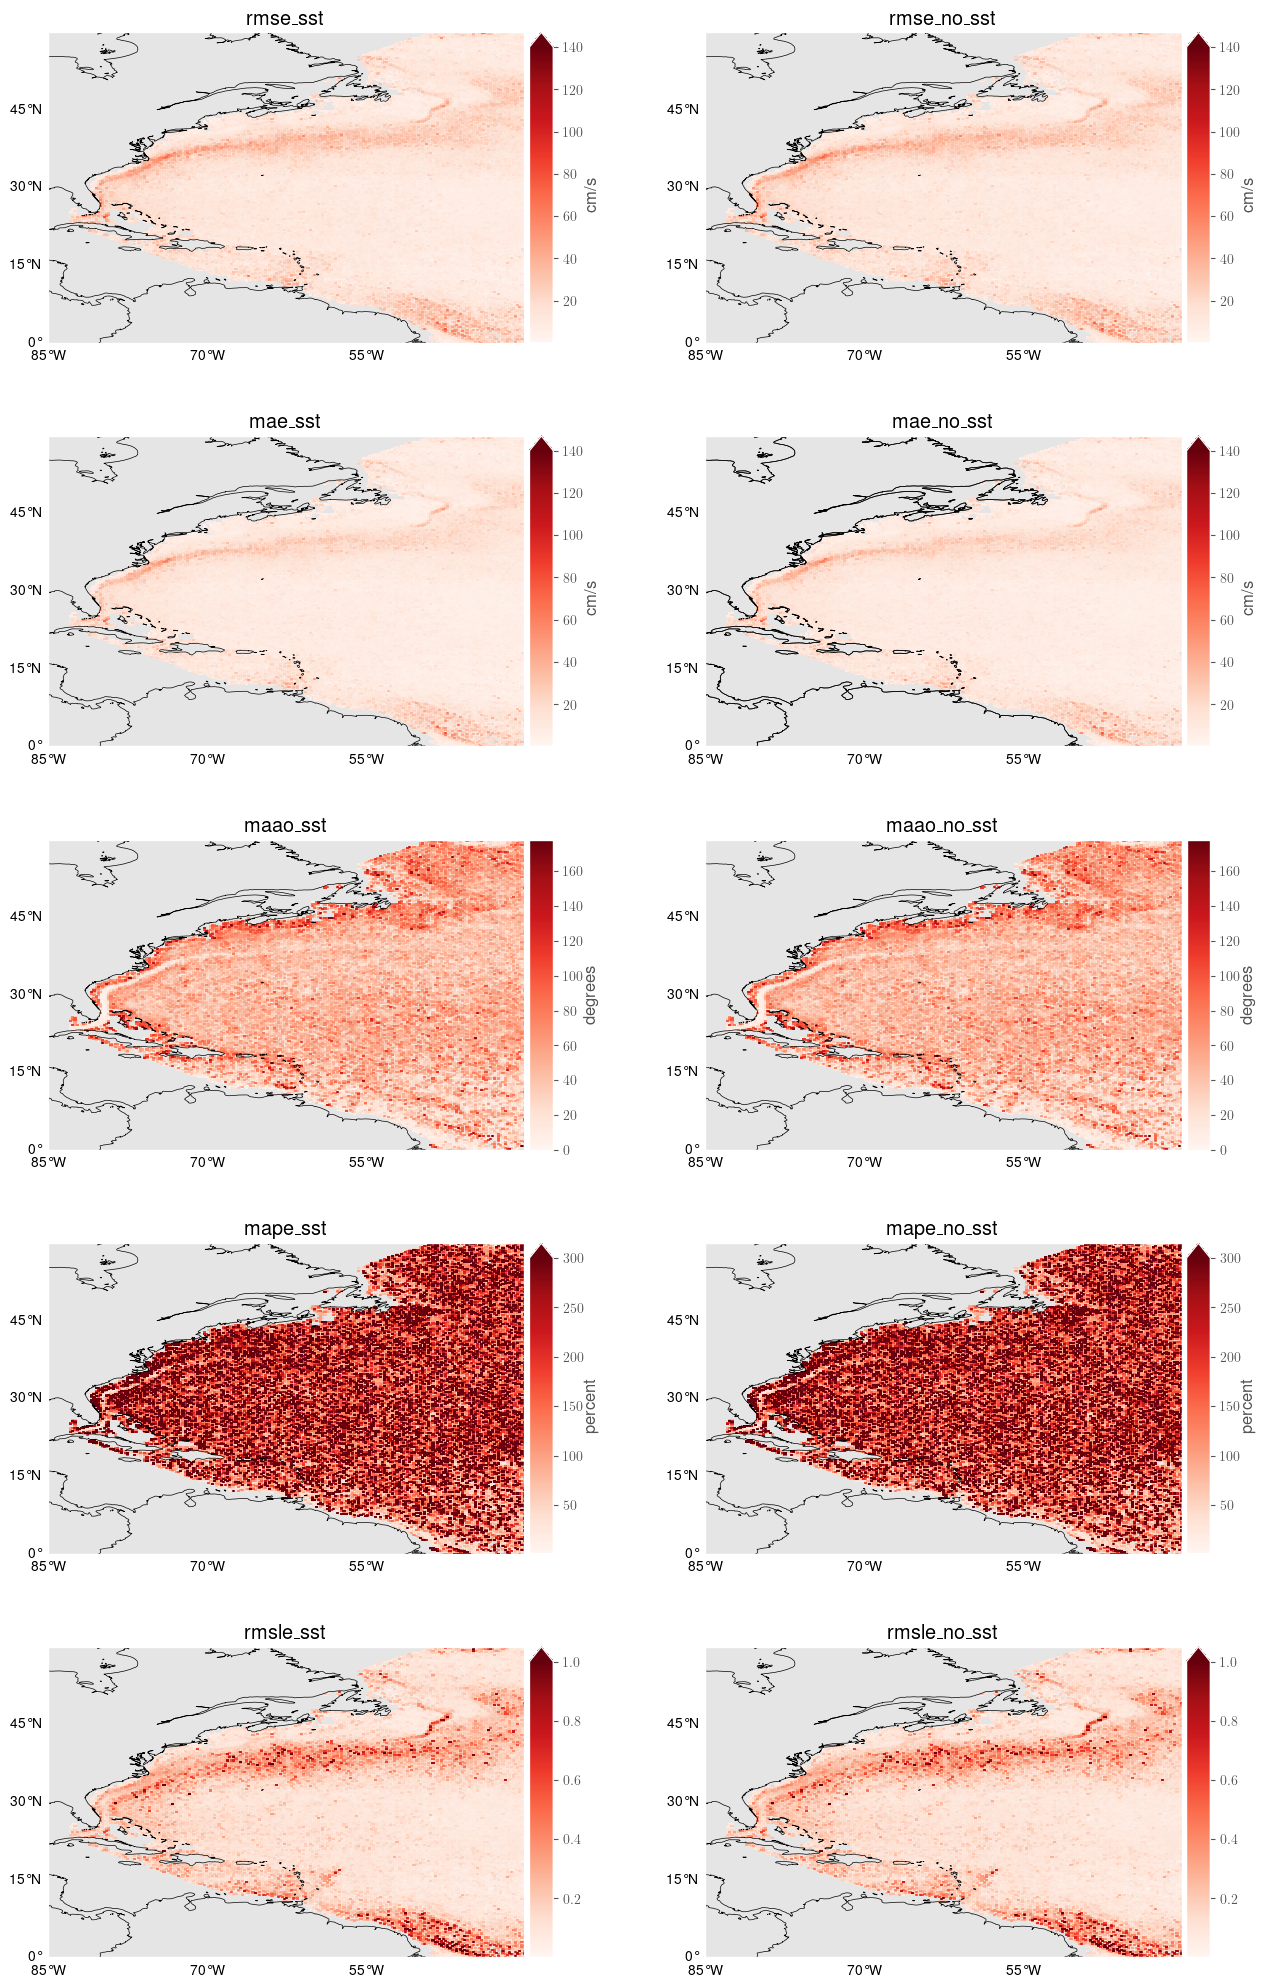

In [ ]:
fig, axs = plt.subplots(5,2,figsize=(15,25), subplot_kw= {"projection":ccrs.PlateCarree()})
metric_names = ['rmse_sst', 'rmse_no_sst','mae_sst', 'mae_no_sst','maao_sst','maao_no_sst','mape_sst','mape_no_sst','rmsle_sst','rmsle_no_sst']
titles = metric_names
cbar_names = [r"cm/s", r"cm/s",r"cm/s",r"cm/s", r"degrees", r"degrees", "percent", "percent", "", "" ]
extent = [-85.01,#summaries['lon'].min(),
          full_data['lon'].max(),
          -0.01,
          full_data['lat'].max()
         ]

print('fig successful')
for ii, metric in enumerate(metric_names):
    col = int(ii%2)
    row = int((ii-col)/2)
    current_ax = axs[row,col]
    if metric == 'rmse_sst' or metric == 'rmse_no_sst':
        vmax_manual = 140
    elif metric == 'maao_sst' or metric == 'maao_no_sst':
        vmax_manual = 180
    elif metric == 'mape_sst' or metric == 'mape_no_sst':
        vmax_manual = 500
    elif metric == 'rmsle_sst' or metric == 'rmsle_no_sst':
        vmax_manual = 2
    cax = plot_column(errs,
                      metric,
                      ax=current_ax,
                      cmap='Reds',vmax_manual=vmax_manual)
    print(f'{metric} plot successful')
    current_ax.set_title(titles[ii])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[ii], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[1,1].coastlines()
axs[1,1].set_aspect('auto')

plt.show()

### Uncertainty Reduction

2. Including SST gradient in the MVN NGBoost model reduces the variance of:
- RMSE
- MAE
- MAAO
- MAPE

##### Formulate Fisher Test
100 replications of MVN NGBoost fitting with different random seeds for each replication so that each replication is *independent*.

RMSE samples are approximately normally distributed ($p=0.92) as calulcated above.

**Check homoscedasticity: Levene Test**

In [117]:
# check samples are homoscedastic
alpha = 0.05

_, p_sst = scipy.stats.levene(X_SST_grad)
_, p_0 = scipy.stats.levene(X_0)

test_pairs = [['X_SST_grad',p_sst],['X_0',p_0]]
for pair in test_pairs:
    if pair[1] < alpha:
        print(f"\n{pair[0]} is not homoscedastic.")
        print(f"p = {pair[1]:.2f}")
    else:
        print(f"\n{pair[0]} is homoscedastic.")
        print(f"p = {pair[1]:.2f}")

ValueError: Must enter at least two input sample vectors.

Fisher test:

Let $s^2_{\nabla SST} = \frac{1}{N-1}\sum_{n=1}^N \left(X_{\nabla SST}^{(n)}-\bar{X}_{\nabla SST}\right)^2$, $s^2_0 = \frac{1}{N-1}\sum_{n=1}^N \left(X_{0}^{(n)}-\bar{X}_{0}\right)^2$ be the sample variances of $X_{\nabla SST}^{(1)}, \dots, X_{\nabla SST}^{(N)}$ and $X_{0}^{(1)}, \dots, X_{0}^{(N)}$  where $N=100$, respectively.

$H_0$: $s^2_{\nabla SST}$ < $s^2_0$.

$H_1$: $s^2_{\nabla SST} \geq s^2_0$.

Test statistic: $F = \frac{s^2_{\nabla SST}}{s^2_0}$ with $N-1,N-1$ degrees of freedom.

In [ ]:
# plot observations as histograms
plt.hist(X_SST_grad, bins = 15, alpha = 0.5, color = "blue", label = r"$X_{\nabla SST}$")
plt.hist(X_0, bins = 15, alpha = 0.5, color = "red", label = r"$X_0$")
plt.title("Histogram of Observations")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# set up for f-test
var1, var2 = np.var(X_SST_grad, ddof = 1), np.var(X_0, ddof = 1)
df1, df2 = len(X_SST_grad) - 1, len(X_0) - 1

#manual 
## note: f-statistic is defined to be larger than 1
print(var1/var2)
f_stat = np.max(var1/var2, var2/var1)
p_two_sided = 2*(1-scipy.stats.f.cdf(f_stat, df1, df2))
'''
# plot the F-distribution
x = np.linspace(0, 5, 1000)  # Range of F-values for plotting
f_dist = scipy.stats.f.pdf(x, df1, df2)  # F-distribution density function

# plot F-distribution
plt.plot(x, f_dist, label = f"F-distribution (df1 = {df1}, df2 = {df2})")
plt.axvline(f_stat, color = "red", linestyle = "--", label = f"Observed F = {f_stat:.2f}")
plt.fill_between(x, f_dist, where = (x >= f_stat), color = "red", alpha = 0.3, label = "Rejection region")
plt.title("F-distribution and observed F-statistic")
plt.xlabel("F value")
plt.ylabel("Density")
plt.legend()
plt.show()'''

# Interpret result (significance level 0.05)
alpha = 0.05
if p_two_sided < alpha:
    print("Reject H0: Samples come from distributions with different variances.")
else:
    print("Fail to reject H0: Samples come from distributions with the same variance.")

print(f'var_sst={var1}')
print(f'var_0={var2}')

3. Including SST Gradient in the MVN NGBoost model reduces the area of the prediction region.

### Goodness of Fit
4. Including SST gradient in MVN NGBoost improves fit of the model to the data in:
- NLL
- $\chi^2$
- Prediction region coverage

In [ ]:
# this is code from MV_Prediction - adapt as necessary

def NLL(dists, y):
    N = y.shape[0]
    nlls = [-dists[i].logpdf(y[i, :]) for i in range(N)]
    return nlls

def in_ci(error, sigma, alpha=0.95):
    crit_val = scipy.stats.chi2.ppf(alpha, sigma.shape[0])
    sigma_inv = np.linalg.inv(sigma)
    n = error.T @ sigma_inv @ error
    return n < crit_val

def coverage(dists, y, alpha=0.90):
    N = y.shape[0]
    covs = [dists[i].cov for i in range(N)]
    diffs = [y[i, :] - dists[i].mean for i in range(N)]
    ret = [in_ci(diff, cov, alpha=alpha) for diff, cov in zip(diffs, covs)]
    return ret

def matrix_area(mat, mult):
    p = mat.shape[0]
    return (
        2
        * (np.pi ** (p / 2))
        / scipy.special.gamma(p / 2)
        / p
        * (np.linalg.det(mat) ** 0.5)
        * mult ** (p / 2)
    )

def area(dists, y, alpha: float = 0.90):
    N = y.shape[0]
    covs = [dists[i].cov for i in range(N)]
    # TODO: Check this is correct for the area
    area = [matrix_area(cov, scipy.stats.ppf(alpha, cov.shape[1])) for cov in covs]
    return area

### SST Gradient as Physical Phenomena

5. SST gradients are significant features for explaining the variance of the MVN NGBoost parameters.

6. SST gradients improve prediction significantly in the Gulf Stream and Labrador Current regions.


### Polar Form

Including the velocities in polar form does all the above things

## The SeaDucks Implementation

7. The SeaDucks implementation of MVN NGBoost improves upon the model presented by O'Malley et al. (2023) on the mean of:
- RMSE
- NLL
- Prediction Region Area
- Prediction Region Coverage

8. The SeaDucks implementation of MVN NGBoost improves upon the model presented by O'Malley et al. (2023) on the variance of:
- RMSE
- NLL
- Prediction Region Area
- Prediction Region Coverage


## Observations about the MVN NGBoost Model

9. Increasing the number of training points increases the model's reliance on (lat, lon, time) and decreases the reliance on physical features.

10. There is seasonal variation in the performance of MVN NGBoost.


11. The model residuals are normally distributed
- linear
- angular

In [ ]:
# check samples are normally distributed
alpha = 0.05

metric_names = []

for ii in range(len(metric_names)):
    _, p_sst = scipy.stats.normaltest(np.array(errs[[metric_names[2*ii]]]))
    print(np.array(errs[[metric_names[2*ii]]]))
    _, p_0 = scipy.stats.normaltest(np.array(errs[[metric_names[2*ii+1]]]))

    test_pairs = [['X_SST_grad',p_sst],['X_0',p_0]]
    for jj,pair in enumerate(test_pairs):
        if pair[1] < alpha:
            print(f"\n{pair[0]} does not follow a normal distribution for {metric_names[2*ii+jj]}.")
            print(f"p = {pair[1]}")
        else:
            print(f"\n{pair[0]} follows a normal distribution {metric_names[2*ii+jj]}.")
            print(f"p = {pair[1]}")

[[12.1958215 ]
 [12.1958215 ]
 [12.1958215 ]
 ...
 [ 2.79290005]
 [ 2.79290005]
 [ 5.09946502]]

X_SST_grad does not follow a normal distribution for rmse_sst.
p = [0.]

X_0 does not follow a normal distribution for rmse_no_sst.
p = [0.]
[[8.34318642]
 [8.34318642]
 [8.34318642]
 ...
 [2.38765607]
 [2.38765607]
 [4.4907097 ]]

X_SST_grad does not follow a normal distribution for mae_sst.
p = [0.]

X_0 does not follow a normal distribution for mae_no_sst.
p = [0.]


ValueError: data type <class 'numpy.object_'> not inexact

12. There are clusters of regions that perform poorly in the following metrics:
- RMSE
- MAE
- MAAO
- MAPE

## Mean Absolute Angle Offset

13. MAAO gives us more information about improvements in direction prediction than RMSE.